In [1]:
import os
import shutil

# Source directory
source_dir = r"C:\Users\Rakes\OneDrive\Desktop\project1\SCVD\SCVD_converted_sec_split"

# Target directory
binary_dir = r"C:\Users\Rakes\OneDrive\Desktop\project1\binary_split"
os.makedirs(binary_dir, exist_ok=True)

for split in ['train', 'test']:
    for label in ['Normal', 'Violence']:
        src = os.path.join(source_dir, split, label)
        dst = os.path.join(binary_dir, split, label)
        shutil.copytree(src, dst, dirs_exist_ok=True)

print("✅ Only 'Normal' and 'Violence' folders copied.")


✅ Only 'Normal' and 'Violence' folders copied.


In [2]:
import cv2
import os
from tqdm import tqdm

def extract_5_frames_per_video(source_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for split in ['train', 'test']:
        for label in ['Normal', 'Violence']:
            label_dir = os.path.join(source_dir, split, label)
            output_label_dir = os.path.join(output_dir, split, label)
            os.makedirs(output_label_dir, exist_ok=True)

            for video_file in tqdm(os.listdir(label_dir), desc=f"{split}/{label}"):
                if not video_file.endswith('.avi'):
                    continue

                video_path = os.path.join(label_dir, video_file)
                cap = cv2.VideoCapture(video_path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                interval = max(frame_count // 5, 1)  # get 5 evenly spaced frames
                basename = os.path.splitext(video_file)[0]
                video_out_dir = os.path.join(output_label_dir, basename)
                os.makedirs(video_out_dir, exist_ok=True)

                frame_idx = 0
                saved = 0
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    if frame_idx % interval == 0 and saved < 5:
                        frame_resized = cv2.resize(frame, (128, 128))
                        out_path = os.path.join(video_out_dir, f"{saved}.jpg")
                        cv2.imwrite(out_path, frame_resized)
                        saved += 1
                    frame_idx += 1
                cap.release()

extract_5_frames_per_video(
    source_dir=r"C:\Users\Rakes\OneDrive\Desktop\project1\binary_split",
    output_dir=r"C:\Users\Rakes\OneDrive\Desktop\project1\binary_frames"
)


test/Violence: 100%|██████████| 118/118 [00:11<00:00, 10.21it/s]


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_dir = r"C:\Users\Rakes\OneDrive\Desktop\project1\binary_frames\train"
test_dir = r"C:\Users\Rakes\OneDrive\Desktop\project1\binary_frames\test"

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

# No augmentation for test, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and test data
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'  # binary labels now
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 9210 images belonging to 2 classes.
Found 1435 images belonging to 2 classes.


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # Unfreeze base

# Freeze all except last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary = sigmoid

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 1,608,449 (6.14 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [5]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10
)

c:\Users\Rakes\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1316s 5s/step - accuracy: 0.8394 - loss: 0.3388 - val_accuracy: 0.9686 - val_loss: 0.0976
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 72s 249ms/step - accuracy: 0.9824 - loss: 0.0511 - val_accuracy: 0.9972 - val_loss: 0.0091
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 67s 234ms/step - accuracy: 0.9914 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 63s 220ms/step - accuracy: 0.9908 - loss: 0.0229 - val_accuracy: 1.0000 - val_loss: 5.6781e-04
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 63s 217ms/step - accuracy: 0.9942 - loss: 0.0163 - val_accuracy: 0.9993 - val_loss: 0.0010
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 55s 191ms/step - accuracy: 0.9940 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 5.3202e-04
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 65s 224ms/step - accuracy: 0.9973 - loss: 0.0080 - val_accuracy: 0.9965 - val_loss: 0.0078
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 65s 226ms/step - accuracy: 0.9957 - 

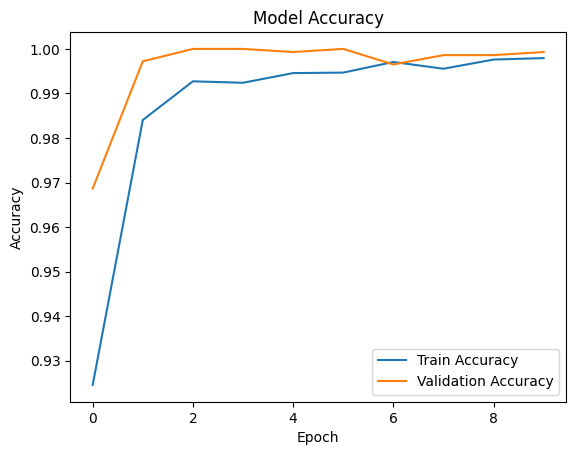

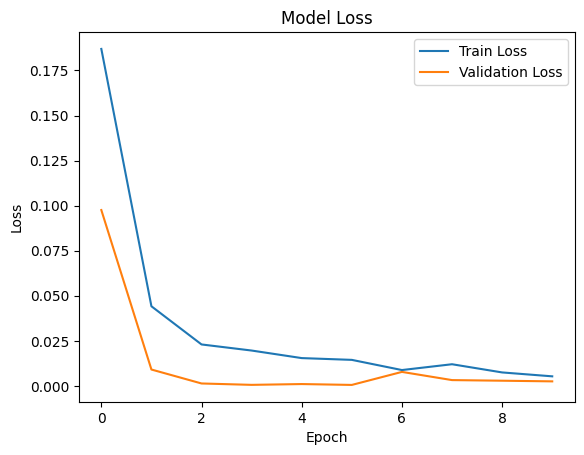

In [6]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step


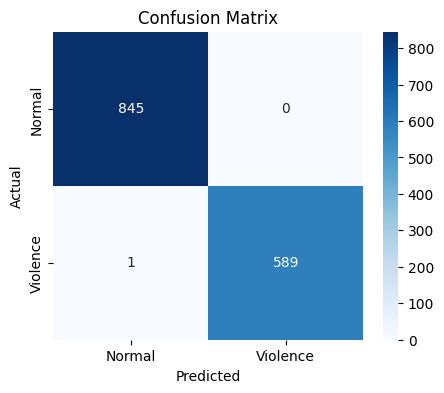


Classification Report:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       845
    Violence       1.00      1.00      1.00       590

    accuracy                           1.00      1435
   macro avg       1.00      1.00      1.00      1435
weighted avg       1.00      1.00      1.00      1435



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict on test data
Y_pred = model.predict(test_gen)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Violence'], yticklabels=['Normal', 'Violence'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Violence']))


In [8]:
import os
import numpy as np
import cv2

def predict_video_folder(model, folder_path):
    """
    Predicts class for a folder containing 5 frames.
    Applies majority voting over the 5 frames.
    """
    predictions = []
    for i in range(5):
        frame_path = os.path.join(folder_path, f"{i}.jpg")
        if not os.path.exists(frame_path):
            continue
        img = cv2.imread(frame_path)
        img = cv2.resize(img, (128, 128))
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        pred_class = int(pred[0][0] > 0.5)  # binary classification
        predictions.append(pred_class)
    
    if len(predictions) == 0:
        return "Unknown"
    
    final = 1 if predictions.count(1) > predictions.count(0) else 0
    return "Violence" if final == 1 else "Normal"


In [9]:
folder = r"C:\Users\Rakes\OneDrive\Desktop\project1\binary_frames\test\Violence\Violence-Test003"
result = predict_video_folder(model, folder)
print("Prediction:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction: Violence


In [10]:
model.save("violence_detector_model.keras")
print("✅ Model saved!")


✅ Model saved!


In [15]:
import streamlit as st
import zipfile
import os
import shutil
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load model
model = load_model("violence_detector_model.keras")

# Helper: Extract zip and predict
def predict_frames(model, folder_path):
    predictions = []
    for i in range(5):
        frame_path = os.path.join(folder_path, f"{i}.jpg")
        if os.path.exists(frame_path):
            img = cv2.imread(frame_path)
            img = cv2.resize(img, (128, 128))
            img = img.astype("float32") / 255.0
            img = np.expand_dims(img, axis=0)
            pred = model.predict(img)
            predictions.append(pred[0][0])
    
    if not predictions:
        return "No valid frames", 0.0

    avg_conf = np.mean(predictions)
    final_class = "Violence" if avg_conf > 0.5 else "Normal"
    return final_class, avg_conf

# Streamlit UI
st.title("🔍 CCTV Violence Detection")
st.write("Upload 5-frame zip from a CCTV clip to classify as **Normal** or **Violence**.")

# Upload ZIP
uploaded_file = st.file_uploader("📁 Upload ZIP file containing 5 frames (0.jpg to 4.jpg)", type="zip")

if uploaded_file:
    temp_dir = "temp_frames"
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir, exist_ok=True)

    # Extract zip
    with zipfile.ZipFile(uploaded_file, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Predict
    with st.spinner("Predicting..."):
        label, confidence = predict_frames(model, temp_dir)
    
    st.success(f"✅ Prediction: **{label}**")
    st.progress(confidence if confidence < 1 else 1)
    st.write(f"Confidence Score: `{confidence:.2f}`")

    # Clean up
    shutil.rmtree(temp_dir)


2025-03-23 02:16:42.487 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 02:16:42.801 
  command:

    streamlit run C:\Users\Rakes\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-03-23 02:16:42.802 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 02:16:42.804 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 02:16:42.804 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 02:16:42.805 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 02:16:42.805 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 02:16:42.806 Thre